In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime
import json
import random
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from pandas.tseries.offsets import Day
import pytz

# carbon_intensity_202208

In [30]:
base_url = "https://api.carbonintensity.org.uk"

# Function to get Carbon Intensity data for a specific date
def get_intensity_for_date(date):
    endpoint = f"/intensity/date/{date}"
    response = requests.get(base_url + endpoint)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Function to generate dates for the entire month of August 2022
def generate_dates_for_august_2022():
    start_date = "2022-08-01"
    end_date = "2022-08-31"

    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date)
        year, month, day = map(int, current_date.split("-"))
        next_day = (datetime.date(year, month, day) + datetime.timedelta(days=1)).isoformat()
        current_date = next_day

    return dates

# Main function to fetch data for the entire month of August 2022
def get_data_for_august_2022():
    dates = generate_dates_for_august_2022()
    data = []

    for date in dates:
        intensity_data = get_intensity_for_date(date)
        if intensity_data:
            data.append(intensity_data)

    return data

# Call the main function to get the data
august_2022_data = get_data_for_august_2022()

# Print the data
# print(august_2022_data)

In [34]:
# Create lists to store the values for each field
from_time_list = []
to_list = []
forecast_intensity_list = []
actual_intensity_list = []
index_list = []

# Loop through the data and extract values for each field
for date_data in august_2022_data:
    for time_data in date_data['data']:
        from_time_list.append(time_data['from'])
        to_list.append(time_data['to'])
        forecast_intensity_list.append(time_data['intensity']['forecast'])
        actual_intensity_list.append(time_data['intensity']['actual'])
        index_list.append(time_data['intensity']['index'])

# Create a DataFrame from the lists
df = pd.DataFrame({
    'from': from_time_list,
    'to': to_list,
    'forecast_intensity': forecast_intensity_list,
    'actual_intensity': actual_intensity_list,
    'index': index_list
})

df = df.sort_values('from')

df

,from,to,forecast_intensity,actual_intensity,index
0,2022-07-31T23:00Z,2022-07-31T23:30Z,286,311,very high
1,2022-07-31T23:30Z,2022-08-01T00:00Z,298,314,very high
2,2022-08-01T00:00Z,2022-08-01T00:30Z,304,315,very high
3,2022-08-01T00:30Z,2022-08-01T01:00Z,315,318,very high
4,2022-08-01T01:00Z,2022-08-01T01:30Z,318,321,very high
...,...,...,...,...,...
1483,2022-08-31T20:30Z,2022-08-31T21:00Z,226,218,high
1484,2022-08-31T21:00Z,2022-08-31T21:30Z,228,216,high
1485,2022-08-31T21:30Z,2022-08-31T22:00Z,222,215,high
1486,2022-08-31T22:00Z,2022-08-31T22:30Z,219,212,high


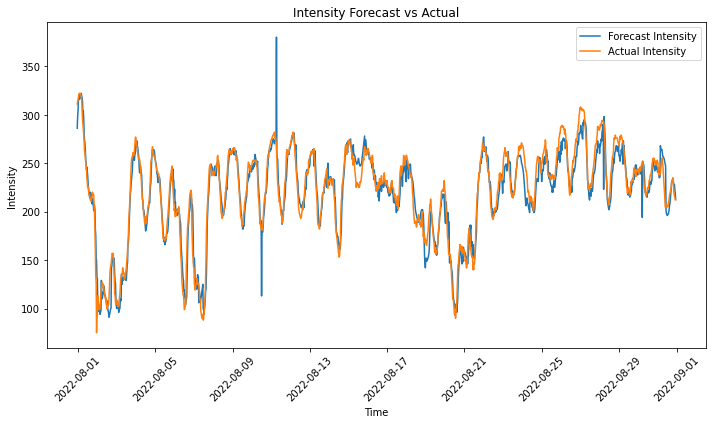

In [35]:
df['from'] = pd.to_datetime(df['from'])
df['to'] = pd.to_datetime(df['to'])

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(df['from'], df['forecast_intensity'], label='Forecast Intensity')
plt.plot(df['from'], df['actual_intensity'], label='Actual Intensity')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Intensity Forecast vs Actual')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [11]:
# 计算 actual_intensity 的平均值
average_actual_intensity = df['actual_intensity'].mean()

print("平均 actual_intensity 值:", average_actual_intensity)

平均 actual_intensity 值: 220.7298387096774


In [6]:
# # Convert 'from' and 'to' columns to datetime objects for proper calculation
# df['from'] = pd.to_datetime(df['from'])
# df['to'] = pd.to_datetime(df['to'])

# Calculate the forecast error (Mean Absolute Error -dfMAE)
df['forecast_error'] = abs(df['actual_intensity'] - df['forecast_intensity'])

# Calculate the Mean Absolute Error (MAE)
mae = df['forecast_error'].mean()

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 9.448924731182796


In [39]:
# 根据index分组，计算每组的actual_intensity范围和数据点数量
index_ranges = df.groupby('index').agg({'actual_intensity': ['min', 'max'], 'index': 'size'})

index_ranges.columns = ['min_intensity', 'max_intensity', 'data_count']

print(index_ranges)

           min_intensity  max_intensity  data_count
index                                              
high                 210            308        1014
low                   75            129         101
moderate             130            209         361
very high            311            322          12


# forecast

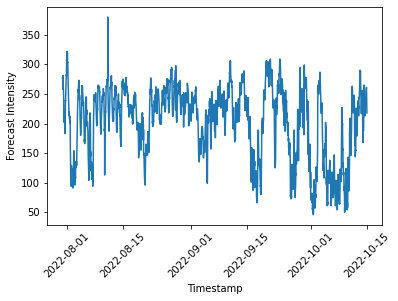

/Users/xuanhaoding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


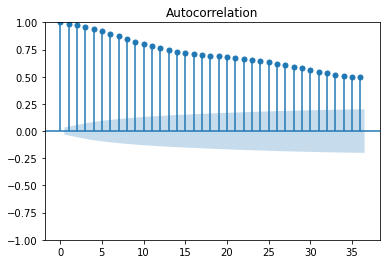

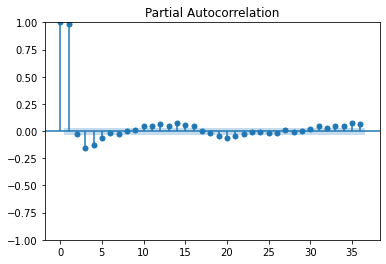

In [52]:
# 1. 加载数据和预处理
data = df
data['from'] = pd.to_datetime(data['from'])
data.set_index('from', inplace=True)

# 2. 可视化数据
plt.plot(data['forecast_intensity'])
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.ylabel('Forecast Intensity')
plt.show()

# Plot ACF and PACF to determine p, d, q values
plot_acf(data['forecast_intensity'])
plot_pacf(data['forecast_intensity'])
plt.show()

In [53]:
p, d, q = 1, 1, 1  # 用您确定的值进行替换
model = sm.tsa.ARIMA(data['forecast_intensity'], order=(p, d, q))
results = model.fit()

/Users/xuanhaoding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/Users/xuanhaoding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/Users/xuanhaoding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


In [54]:
# 将字符串日期转换为时间戳对象，并为其指定时区
start_date = pd.Timestamp('2022-07-31', tz=pytz.UTC)
end_date = pd.Timestamp('2022-10-14', tz=pytz.UTC)

# 使用 DateOffset 创建日期范围
date_range = pd.date_range(start=start_date, end=end_date, freq=Day())

# 预测时间范围内的值
predictions = results.predict(start=start_date, end=end_date, dynamic=False)

# 从原始数据中提取实际值
actual_values = data['forecast_intensity'][start_date:end_date]

mae = mean_absolute_error(actual_values, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 5.579831221691041


In [55]:
df['forecast_error_5%'] = predictions

# 将索引列重新变为普通的数据列
df.reset_index(inplace=True)

# 将 'from' 列的时间戳格式转换为与 'to' 列相同的格式
df['from'] = pd.to_datetime(df['from'], utc=True).dt.strftime('%Y-%m-%dT%H:%MZ')

df

,from,level_0,to,forecast_intensity,actual_intensity,index,forecast_error_5%
0,2022-07-30T23:30Z,0,2022-07-31T00:00Z,278,290,high,NaN
1,2022-07-31T00:00Z,1,2022-07-31T00:30Z,276,287,high,278.002404
2,2022-07-31T00:30Z,2,2022-07-31T01:00Z,281,285,high,275.808761
3,2022-07-31T01:00Z,3,2022-07-31T01:30Z,281,282,high,281.317885
4,2022-07-31T01:30Z,4,2022-07-31T02:00Z,258,281,high,281.220702
...,...,...,...,...,...,...,...
3644,2022-10-14T21:30Z,3644,2022-10-14T22:00Z,252,238,high,NaN
3645,2022-10-14T22:00Z,3645,2022-10-14T22:30Z,248,226,high,NaN
3646,2022-10-14T22:30Z,3646,2022-10-14T23:00Z,234,220,high,NaN
3647,2022-10-14T23:00Z,3647,2022-10-14T23:30Z,221,209,moderate,NaN


In [28]:
df.to_csv('carbon_intensity_202208.csv', index=False)

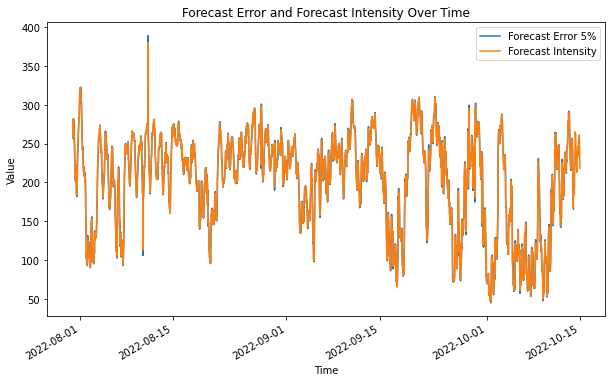

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的数据已经存储在一个名为 df 的 DataFrame 中

# 转换时间列的格式
df['from'] = pd.to_datetime(df['from'])

# 设置图表大小
plt.figure(figsize=(10, 6))

# 绘制 forecast_error_5% 列的折线图
plt.plot(df['from'], df['forecast_error_5%'], label='Forecast Error 5%')

# 绘制 forecast_intensity 列的折线图
plt.plot(df['from'], df['forecast_intensity'], label='Forecast Intensity')

# 设置标题和标签
plt.title('Forecast Error and Forecast Intensity Over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 自动调整日期显示格式
plt.gcf().autofmt_xdate()

# 显示图表
plt.show()
